# Sorting Arrays

Up to this point we have been concerned mainly with tools to access and operate on array data with NumPy. This section covers algorithms related to sorting values in NumPy arrays. These algorithms are a favorite topic in introductory computer science courses: if you've ever taken one, you probably have had dreams (or, depending on your temperament, nightmares) about insertion sorts, selection sorts, merge sorts, quick sorts, bubble sorts, and many, many more. All are means of accomplishing a similar task: sorting the values in a list or array.

For example, a simple selection sort repeatedly finds the minimum value from a list, and makes swaps until the list is sorted. We can code this in just a few lines of Python:

In [1]:
import numpy as np

def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [2]:
x = np.array([2, 1, 4, 3, 5])
selection_sort(x)

array([1, 2, 3, 4, 5])

As any first-year computer science major will tell you, the selection sort is useful for its simplicity, but is much too slow to be useful for larger arrays. For a list of N values, it requires N loops, each of which does on order ∼N comparisons to find the swap value. In terms of the "big-O" notation often used to characterize these algorithms (see Big-O Notation), selection sort averages O[N2]: if you double the number of items in the list, the execution time will go up by about a factor of four.

Even selection sort, though, is much better than my all-time favorite sorting algorithms, the bogosort:

In [3]:
def bogosort(x):
    while np.any(x[:-1] > x[1:]):
        np.random.shuffle(x)
    return x

In [4]:
x = np.array([2, 1, 4, 3, 5])
bogosort(x)

array([1, 2, 3, 4, 5])

This silly sorting method relies on pure chance: it repeatedly applies a random shuffling of the array until the result happens to be sorted. With an average scaling of O[N×N!], (that's N times N factorial) this should–quite obviously–never be used for any real computation.

Fortunately, Python contains built-in sorting algorithms that are much more efficient than either of the simplistic algorithms just shown. We'll start by looking at the Python built-ins, and then take a look at the routines included in NumPy and optimized for NumPy arrays.

# Fast Sorting in NumPy: np.sort and np.argsort
Although Python has built-in sort and sorted functions to work with lists, we won't discuss them here because NumPy's np.sort function turns out to be much more efficient and useful for our purposes. By default np.sort uses an O[NlogN], quicksort algorithm, though mergesort and heapsort are also available. For most applications, the default quicksort is more than sufficient.

To return a sorted version of the array without modifying the input, you can use np.sort

In [5]:
x = np.array([2, 1, 4, 3, 5])
np.sort(x)

array([1, 2, 3, 4, 5])

If you prefer to sort the array in-place, you can instead use the sort method of arrays:

In [7]:
x.sort()
print(x)

[1 2 3 4 5]


A related function is argsort, which instead returns the indices of the sorted elements:

In [8]:
x = np.array([2, 1, 4, 3, 5])
i = np.argsort(x)
print(i)

[1 0 3 2 4]


The first element of this result gives the index of the smallest element, the second value gives the index of the second smallest, and so on. These indices can then be used (via fancy indexing) to construct the sorted array if desired:

In [9]:
x[i]

array([1, 2, 3, 4, 5])

Sorting along rows or columns
A useful feature of NumPy's sorting algorithms is the ability to sort along specific rows or columns of a multidimensional array using the axis argument. For example:

In [10]:
rand = np.random.RandomState(42)
X = rand.randint(0, 10, (4, 6))
print(X)

[[6 3 7 4 6 9]
 [2 6 7 4 3 7]
 [7 2 5 4 1 7]
 [5 1 4 0 9 5]]


In [11]:
# sort each column of X
np.sort(X, axis=0)

array([[2, 1, 4, 0, 1, 5],
       [5, 2, 5, 4, 3, 7],
       [6, 3, 7, 4, 6, 7],
       [7, 6, 7, 4, 9, 9]])

In [12]:
# sort each row of X
np.sort(X, axis=1)

array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]])

Keep in mind that this treats each row or column as an independent array, and any relationships between the row or column values will be lost!

Partial Sorts: Partitioning
Sometimes we're not interested in sorting the entire array, but simply want to find the k smallest values in the array. NumPy provides this in the np.partition function. np.partition takes an array and a number K; the result is a new array with the smallest K values to the left of the partition, and the remaining values to the right, in arbitrary order:

In [13]:
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 3)

array([2, 1, 3, 4, 6, 5, 7])

Note that the first three values in the resulting array are the threme smallest in the array, and the remaining array positions contain the remaining values. Within the two partitions, the elements have arbitrary order.

Similarly to sorting, we can partition along an arbitrary axis of a multidimensional array:

In [16]:
np.partition(X, 2, axis=1)

array([[3, 4, 6, 7, 6, 9],
       [2, 3, 4, 7, 6, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 9, 5]])

The result is an array where the first two slots in each row contain the smallest values from that row, with the remaining values filling the remaining slots.

Finally, just as there is a np.argsort that computes indices of the sort, there is a np.argpartition that computes indices of the partition. We'll see this in action in the following section.

Example: k-Nearest Neighbors
Let's quickly see how we might use this argsort function along multiple axes to find the nearest neighbors of each point in a set. We'll start by creating a random set of 10 points on a two-dimensional plane. Using the standard convention, we'll arrange these in a 10×2 array:

In [17]:
X = rand.rand(10, 2)

To get an idea of how these points look, let's quickly scatter plot them:

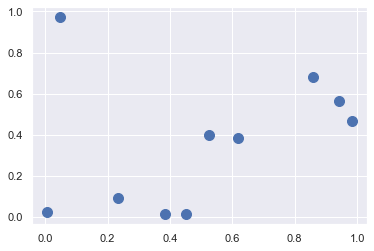

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling
plt.scatter(X[:, 0], X[:, 1], s=100);

Now we'll compute the distance between each pair of points. Recall that the squared-distance between two points is the sum of the squared differences in each dimension; using the efficient broadcasting (Computation on Arrays: Broadcasting) and aggregation (Aggregations: Min, Max, and Everything In Between) routines provided by NumPy we can compute the matrix of square distances in a single line of code:

In [19]:
dist_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)

This operation has a lot packed into it, and it might be a bit confusing if you're unfamiliar with NumPy's broadcasting rules. When you come across code like this, it can be useful to break it down into its component steps:

In [21]:
# for each pair of points, compute differences in their coordinates
differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
differences.shape

(10, 10, 2)

In [22]:
# square the coordinate differences
sq_differences = differences ** 2
sq_differences.shape

(10, 10, 2)

In [23]:
# sum the coordinate differences to get the squared distance
dist_sq = sq_differences.sum(-1)
dist_sq.shape

(10, 10)

Just to double-check what we are doing, we should see that the diagonal of this matrix (i.e., the set of distances between each point and itself) is all zero:

In [24]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

It checks out! With the pairwise square-distances converted, we can now use np.argsort to sort along each row. The leftmost columns will then give the indices of the nearest neighbors:

In [25]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 3 9 7 1 4 2 5 6 8]
 [1 4 7 9 3 6 8 5 0 2]
 [2 1 4 6 3 0 8 9 7 5]
 [3 9 7 0 1 4 5 8 6 2]
 [4 1 8 5 6 7 9 3 0 2]
 [5 8 6 4 1 7 9 3 2 0]
 [6 8 5 4 1 7 9 3 2 0]
 [7 9 3 1 4 0 5 8 6 2]
 [8 5 6 4 1 7 9 3 2 0]
 [9 7 3 0 1 4 5 8 6 2]]


Notice that the first column gives the numbers 0 through 9 in order: this is due to the fact that each point's closest neighbor is itself, as we would expect.

By using a full sort here, we've actually done more work than we need to in this case. If we're simply interested in the nearest k neighbors, all we need is to partition each row so that the smallest k+1 squared distances come first, with larger distances filling the remaining positions of the array. We can do this with the np.argpartition function: